Challenge Set 1
Topic:        Explore MTA turnstile data
Date:         18/04/2016
Name:         Patrick Nieto
Worked with:  Ian, Lucia, Rachael

In [21]:
from __future__ import division
import csv
from datetime import datetime
import dateutil.parser
from collections import Counter
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150627.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.0M    0 24.0M    0     0  1118k      0 --:--:--  0:00:22 --:--:-- 1375k


In [3]:
with open('turnstile_150627.txt') as f:    #open the link to the data
    reader = csv.reader(f)    #read in the data
    rows = [[cell.strip() for cell in row] for row in reader]

## Challenge 1

In [4]:
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']

In [5]:
raw_readings = {}    #an empty dictionary
for row in rows:    #loop over the elements in the list rows
    raw_readings.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))    #loop over the rows, add new keys to the dictionary 
                                            #when the row info is not already present, append to existing data when it is

In [6]:
type(raw_readings)

dict

In [7]:
practice = raw_readings[('J001', 'R460', '01-00-01', 'MARCY AVE')][0]
print(practice)

('JMZ', 'BMT', '06/20/2015', '01:00:00', 'REGULAR', '0007012983', '0001986648')


In [8]:
type(practice)

tuple

## Challenge 2


In [7]:
cumulative_entries = defaultdict(list)
for key, value in raw_readings.items():
    for v in value:
        #date = v[2]
        #time = v[3]
        datetime = dateutil.parser.parse(str(v[2]) + ' ' + str(v[3]))
        updated_value = [datetime, v[5]]
        cumulative_entries[key].append(updated_value)

In [9]:
cumulative_entries[('J001', 'R460', '01-00-01', 'MARCY AVE')][:3]

[[datetime.datetime(2015, 6, 20, 1, 0), '0007012983'],
 [datetime.datetime(2015, 6, 20, 5, 0), '0007013013'],
 [datetime.datetime(2015, 6, 20, 9, 0), '0007013088']]

## Challenge 3

In [10]:
diffsDict = defaultdict(list)
for key, rows in cumulative_entries.items():
    rows.sort(key = lambda x: x[0])
    for i in range(len(rows)-1):
        diffsDict[key].append([rows[i][0], int(rows[i+1][1])-int(rows[i][1])])

In [11]:
diffsDict[('J001', 'R460', '01-00-01', 'MARCY AVE')][:3]

[[datetime.datetime(2015, 6, 20, 1, 0), 30],
 [datetime.datetime(2015, 6, 20, 5, 0), 75],
 [datetime.datetime(2015, 6, 20, 9, 0), 182]]

In [74]:
type(diffsDict)

collections.defaultdict

In [75]:
practice2 = diffsDict[('J001', 'R460', '01-00-01', 'MARCY AVE')][0]
print(practice2)

[datetime.datetime(2015, 6, 20, 1, 0), 30]


In [12]:
dailyCounts = defaultdict(list)

for key, rows in diffsDict.items():
    by_day = {}
    for time in rows:
        day = time[0].date()
        if time[1] < 0:
            time[1] = 0
        by_day[day] = by_day.get(day, 0) + time[1]
    dailyCounts[key] = sorted(by_day.items())

In [96]:
print(type(dailyCounts))
      
practice3 = dailyCounts[('J001', 'R460', '01-00-01', 'MARCY AVE')]
practice3

<class 'collections.defaultdict'>


[(datetime.date(2015, 6, 20), 685),
 (datetime.date(2015, 6, 21), 618),
 (datetime.date(2015, 6, 22), 1638),
 (datetime.date(2015, 6, 23), 1591),
 (datetime.date(2015, 6, 24), 1626),
 (datetime.date(2015, 6, 25), 1648),
 (datetime.date(2015, 6, 26), 1414)]

## Challenge 4

In [15]:
%matplotlib inline

In [79]:
type(dailyCounts)

collections.defaultdict

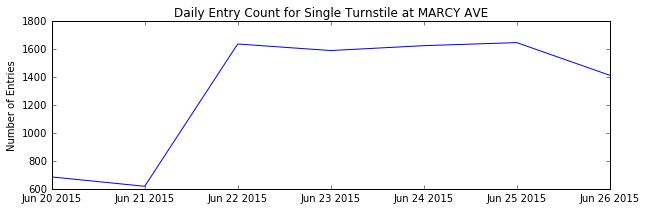

In [64]:
counts = []
dates = []
for date, count in dailyCounts[('J001', 'R460', '01-00-01', 'MARCY AVE')]:
    counts.append(count)
    dates.append(date)

plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Daily Entry Count for Single Turnstile at MARCY AVE')
plt.ylabel('Number of Entries')
    

## Challenge 5

In [25]:
dailyTurnstileCounts = defaultdict(dict)

# Create a dictionary that changes key from previous dictionary to not include C/A
for stationInfo, values in dailyCounts.items():
    unique = (stationInfo[0],stationInfo[1],stationInfo[3])
    if unique in dailyTurnstileCounts:
        existing_data = dailyTurnstileCounts.get(unique)
        for day in values:
            existing_data[day[0]] = existing_data.get(day[0], 0) + day[1]
    else:
        temp = OrderedDict()
        for day in sorted(values):
            temp[day[0]] = day[1]
        dailyTurnstileCounts[unique] = temp

dailyTurnstileCounts[('J001', 'R460', 'MARCY AVE')]

OrderedDict([(datetime.date(2015, 6, 20), 4881),
             (datetime.date(2015, 6, 21), 4092),
             (datetime.date(2015, 6, 22), 9876),
             (datetime.date(2015, 6, 23), 10123),
             (datetime.date(2015, 6, 24), 10515),
             (datetime.date(2015, 6, 25), 10569),
             (datetime.date(2015, 6, 26), 9101)])

## Challenge 6

In [102]:
dailyStationCounts = defaultdict(dict)

# Create a dictionary that changes key from previous dictionary to not include C/A
for stationInfo, values in dailyCounts.items():
    stationName = stationInfo[3]
    if stationName in dailyStationCounts:
        data = dailyStationCounts.get(stationName)
        for day in values:
            data[day[0]] = data.get(day[0], 0) + day[1]
    else:
        temp = OrderedDict()
        for day in sorted(values):
            temp[day[0]] = day[1]
        dailyStationCounts[stationName] = temp

dailyStationCounts['MARCY AVE']

OrderedDict([(datetime.date(2015, 6, 20), 7566),
             (datetime.date(2015, 6, 21), 6847),
             (datetime.date(2015, 6, 22), 14236),
             (datetime.date(2015, 6, 23), 14356),
             (datetime.date(2015, 6, 24), 15026),
             (datetime.date(2015, 6, 25), 14860),
             (datetime.date(2015, 6, 26), 12716)])

## Challenge 7

In [ ]:
counts = []
dates = []
for date, count in dailyStationCounts[('MARCY AVE')]:
    counts.append(count)
    dates.append(date)


plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Daily Entry Count at MARCY AVE')
plt.ylabel('Number of Entries')

## Challenge 8